<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [ ]:
#| default_exp tree

代码复现说明
```shell
pip install git+https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data.git
pip install ray optuna seaborn matplotlib sklearn
```
我们的代码导出为了python模块形式
```python
from thu_big_data_ml_tree import FastKDTree
```

In [ ]:
#|hide
import matplotlib.pyplot as plt

In [ ]:
#|hide
plt.style.use('default')

## 实验目的
> 老师给我们的要求是
> 1. 完成 KD 树算法，并利⽤实现的算法完成数字识别任务
> 2. 对所建模型进行分析评判。

我们不仅完成以上内容，还进行了
1. 参考谷歌调参手册，使用科学的实验设计来对KNN分类算法的元参数进行搜索，从而实现更高的分类精度。
2. 参考前沿论文，尝试修改KD树的训练策略，从而对KD树的推理速度进行改进。

## 实验数据
> MNIST 数据库是由 Yann et. al. 提供的⼿写数字数据库⽂件, 官网地址为 http://yann.lecun.com/exdb/mnist/。
> 主要包含了 60000 张的训练图像和 10000 张的测试图像
> ```python
> from sklearn.datasets import fetch_openml
> from sklearn.model_selection import train_test_split
> from sklearn.neighbors import KNeighborsClassifier
> from sklearn.metrics import accuracy_score
> import numpy as np
> # 获取MNIST数据集,并抽样一部分数据以便后续的计算
> idx = np.random.choice(70000,5000,replace=False)
> mnist = fetch_openml("mnist_784")
> X, y = mnist.data.to_numpy(), mnist.target.to_numpy().astype('int')
> X = X[idx]
> y = y[idx]
> # 划分数据集为训练集和测试集
> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
> 
> ```



以上代码有几个小问题，我们需要改进一下
1. 由于网络环境问题，fetch_openml("mnist_784") 是无法跑通的，会卡死。
事实上，给sklearn贡献过代码的同学可能知道，sklearn还有一个load_digits数据集，这个数据集是sklearn CI（持续集成）测试用例的一部分。这个回归测试通过测试贡献者的新做的改进是否导致性能不如以前的版本，来决定是否接受更改。
因此，我们使用load_digits数据集代替mnist_784数据集来完成这个项目。

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_digits.html

2. 划分数据集时，train_test_split应当使用stratify参数，以确保每一类样本的比例相同。
3. import过多，应该只导入需要的模块。

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
dataset_dict = load_digits()
dataset_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
import numpy as np

In [ ]:
X:np.array = dataset_dict['data']
y:np.array = dataset_dict['target']
X.shape, X.dtype, y.shape, y.dtype

((1797, 64), dtype('float64'), (1797,), dtype('int64'))

划分数据集为训练集和测试集

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=y)
len(X_train), len(X_test)

(1437, 360)

## 实验内容
### KNN和KD树的关系是什么？什么叫基于KD树的KNN算法？

在我们开始实验内容之前，有必要澄清这一理论上的概念。

KNN（K-Nearest Neighbor）算法是一种基本的机器学习算法，既可以用于分类也可以用于回归。
对于新的一个测试样本（未知类别或标签值）来说，它和训练集中每一个样本都有距离，从而存在离测试样本最近的K个样本（当然训练集要大于K啦），然后根据这些样本的已知标签来决定测试样本的标签。

> 我今天学习的《自然辩证法课》上正好讲到一个哲学概念叫做“类比推理”与“演绎推理”。古希腊的哲学家们则发展了形式逻辑，比如亚里士多德的三段论，我们在《数理逻辑导论》课上还了解了罗素、哥德尔等人对整套逻辑的进一步发展。而中国古代的先贤很喜欢类比推理，比如孟子要提倡“舍生而取义者也”，偏偏不和你论证为什么要舍生取义（后文也有一点论证），而是先跟你说他观察到了“二者不可得兼，舍鱼而取熊掌者也。”，然后他认为这两个事情很像，然后告诉你所以要舍生取义；又比如孟子想要说“天将降大任于是人也，必先苦其心志”，他先给了你一个训练集，说好多“降大任”的“人”都是被“苦其心志的”。这个推理看起来很扯，实际上也是也是有一定的统计意义的。

而KD树（k-dimensional tree）是一种用于组织k维空间数据的树形数据结构，它是一种特殊的二叉树。KD树将k维空间进行分割，每个节点代表一个k维超矩形区域。KD树的主要作用是在高维空间中快速地进行最近邻查找，它能够显著减少在KNN算法中计算所有训练样本与测试样本之间距离的需求，从而提高效率。

KNN不一定要使用KD树来进行近邻搜索，事实上还有其他更加高效的数据结构，比如Ball Tree。如果我们说默认的KNN是用暴力方法计算所有距离的逐一比较的话，我们可以说KD树不是KNN算法的一部分，而是KNN算法的一个优化工具，用于在高维空间中快速查找最近邻。


### 基于sklearn的KNN算法实现手写数字识别

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# 创建KNeighborsClassifier模型，使用kd树作为搜索算法
knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')

# 在训练集上训练模型
knn.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = knn.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 98.61%


### 自己实现KD树

In [ ]:
#| export

# 定义KD树节点类
class Node:
    def __init__(self, data, left=None, right=None):
        self.data = data #节点本身的数据
        self.left = left #节点的左子树
        self.right = right #节点右子树

# 递归方法构建KD树

def build_kd_tree(X, depth=0):
    if len(X) == 0:
        return None
    k = X.shape[1]
    axis = depth % k #根据当前深度，选择划分的维度
    X = X[X[:, axis].argsort()]
    median = X.shape[0] // 2 #将当前结点数据一分为二
    return Node(data=X[median], left=build_kd_tree(X[:median], depth + 1), right=build_kd_tree(X[median + 1:], depth + 1))

# 计算点之间的距离，这里使用欧几里得距离
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [ ]:
#| export
from queue import PriorityQueue

In [ ]:
# 这里我们需要注意使用PriorityQueue的一个坑点，same priority 下 会崩溃； PriorityQueue文档没写，heapq写了
# https://docs.python.org/3/library/heapq.html
class TestNode:
    def __init__(self, point):
        self.point = point


test1 = [
    (-13.30413469565007, 1.2),
    (-9.327379053088816, 0.0),
    (-13.30413469565007, 1.4),
]
test2 = [
    (-13.30413469565007, TestNode(1.2)),
    (-9.327379053088816, TestNode(0.0)),
    (-13.30413469565007, TestNode(1.4)),
]

test3 = [
    (0, TestNode(1.2)),
    (1, TestNode(0.0)),
    (2, TestNode(1.4)),
]

test_pq = PriorityQueue()
for t in test1:
    test_pq.put(t)
print(test_pq.get())
test_pq = PriorityQueue()
for t in test3:
    test_pq.put(t)
print(test_pq.get())
# 注意这种情况下报错
# for t in test2:
#     test_pq.put(t)
# print(test_pq.get())

(-13.30413469565007, 1.2)
(0, <__main__.TestNode object>)


In [ ]:
#| export
# 搜索KD树
def search_kd_tree(tree, target, k=3):
    if tree is None:
        return []
    # k_nearest = [] #list用于储存target当前遍历到的k个k近邻
    # 我们使用优先队列来储存k_nearest，从而提高效率，优先队列中的元素为(-距离, 节点)的元组，距离远的先取出来
    # k_nearest_pq = PriorityQueue(maxsize=k)
    k_nearest_pq = PriorityQueue()
    entry_count = 0
    stack = [(tree, 0)] #用于储存待遍历节点的stack
    while stack:
        node, depth = stack.pop() # 节点出栈
        if node is None:
            continue
        # print(" "*4*depth + f"node: {node.data}, depth: {depth}")
        distance = euclidean_distance(target, node.data) #计算需要分类的目标点与节点的距离
        
        # 调换到前面
        axis = depth % target.shape[0] #计算当前深度对应的划分维度
        axis_diff = target[axis] - node.data[axis] #计算该维度下目标点与当前节点的差
        
        #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则另一边的子树也入栈
        can_omit_another_side = True
        # if len(k_nearest) < k: # 当k_nearest未装满时，直接将节点放入
        # if k_nearest.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        if k_nearest_pq.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        # if not k_nearest_pq.full(): # 当k_nearest未装满时，直接将节点放入
            # print(f"not full, put {(-distance, node)}")
            pass #BLANK_1
            # k_nearest.append((node, distance))
            k_nearest_pq.put((-distance, entry_count, node))
            entry_count+=1
            can_omit_another_side = False
        else: #当k_nearest装满时，对比该节点与k_nearest中与目标点距离最远的节点的距离，如果小于则替换，如果大于则不替换
            pass #BLANK_2
            farthest = k_nearest_pq.get()
            farthest_distance = -farthest[0]
            # print(f"full, farthest: {farthest}")
            if distance < farthest_distance:
                # print(f"closer, put {(-distance, node)}")
                # assert isinstance(distance, float)
                # print(k_nearest_pq.queue)
                k_nearest_pq.put((-distance, entry_count, node))
                entry_count+=1
            else:
                k_nearest_pq.put(farthest)
            

            if farthest_distance > abs(axis_diff): 
                can_omit_another_side = False
        
        if axis_diff <= 0: #当差小于0时则，该节点的左子树入栈 #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则右子树也入栈
            pass #BLANK_3
            stack.append((node.left, depth+1))
            if not can_omit_another_side:
                stack.append((node.right, depth+1))
        else:#当差大于0时则，该节点的右子树入栈，#如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则左子树也入栈
            pass #BLANK_4
            stack.append((node.right, depth+1))
            if not can_omit_another_side:
                stack.append((node.left, depth+1))
    # return [data for data, _ in k_nearest] #返回遍历完的kd树后的k_nearest
    # return [data for _, data in k_nearest] #返回遍历完的kd树后的k_nearest
    return [k_nearest_pq.get()[-1].data for i in range(k_nearest_pq.qsize())] #返回遍历完的kd树后的k_nearest

# 使用KNN算法分类
def knn_classifier(X_train, y_train, X_test, k=3):
    y_pred = []
    for i, test_point in enumerate(X_test):
        k_nearest = search_kd_tree(kd_tree, test_point, k)
        # print(k_nearest)
        # print(i)
        labels = [y_train[np.where((X_train == point).all(axis=1))[0][0]] for point in k_nearest]
        counts = np.bincount(labels)#计算k_nearest中样本最多的标签，预测目标样本为该标签
        y_pred.append(np.argmax(counts))
    return y_pred


In [ ]:
# 构建KD树
kd_tree = build_kd_tree(X_train)

In [ ]:
# 使用KNN算法进行分类
k_neighbors = 3
y_pred = knn_classifier(X_train, y_train, X_test, k_neighbors)

# 评估分类性能
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 98.61%


### 超参数调优

实验题目要求我们对 knn 进⾏超参数的搜索。那么什么是超参数搜索呢？为此我们需要理解两个概念——超参数和搜索。

#### 什么是参数？什么是超参数？什么是元参数？

在大数据分析中，我们往往不知道数据的总体，只能获得数据的一个采样。然而我们对数据的总体是什么分布非常感兴趣，这些未知的分布，我们假设可能是由一些参数来决定的，我们需要根据采样出来的数据对总体的参数进行参数估计（Parameter Estimation）。比如说总体是高斯分布，那么高斯分布的均值和方差就是参数。

刚才我们说了参数是什么，那么什么是超参数呢？参数估计我们通常会用极大似然估计方法，但是相比于贝叶斯参数估计来说有一定的局限性。在贝叶斯机器学习中，我们认为参数本身也是有一个概率分布的，而不是确定的值，而描述参数分布的参数，我们称之为超参数。当然，我们可以认为超参数也有其分布，那么就有对应的超超参数，这种多层嵌套的结构称为贝叶斯网络。

对应到机器学习和深度学习中，参数是指参数化模型的权重。但是我们没有在使用贝叶斯估计，并没有说这些模型权重具有一定的分布，那么超参数是怎么一回事呢？事实上，根据谷歌团队提出的《深度学习调优指南》[@tuningplaybookgithub]，深度学习社区错误地把学习率、批处理大小、正则化系数等参数叫做超参数，这是错误的。他们确实决定了模型的假设空间的不同，决定了最终的性能，而且在模型训练过程中不发生变化，而是决定了训练过程，但是他们本身并不是先验分布的参数，严格来说不应该叫做超参数，应该叫做元参数。

#### 什么是搜索？

搜索是人工智能中的重要的方法[@Russell_Norvig_2016]。搜索包括约束可满足问题和最优化问题，以及带有约束的优化问题。
这里我们说的超参数优化，一般来说是带有约束的优化问题。
其中约束是指，有些超参数组合如果错误地选择，会导致机器学习系统崩溃，或者算法无法收敛。

然而这些约束我们很可能是不知道的，需要调参算法本身尝试。
有时候我们发现的约束可能暗示着代码存在错误，或者深度学习模型本身的优化过程不够稳定，如果是后者，可以通过Gradient Clip, 降低学习率等方法来缓解。

#### KNN和KD树有哪些元参数？
上文我们辨析了KNN和KD树的关系，即是否选用KD树作为KNN的近邻搜索算法，本身是KNN的一个元参数，KNN也可以选择Ball Tree、Brute Force等其他近邻搜索算法。

KD树本身也有一些元参数，比如分割方式、节点的选择方式等，这些元参数会影响KD树的构建和搜索的系统性能（时间复杂度、空间复杂度），但是不会影响到机器学习的性能（分类准确率、ROC-AUC等指标）。因为不影响机器学习的性能，在本节我们不讨论KD树的元参数如何调优。我们会在下一节，附加题中，讨论不同的KD树构建方式对搜索速度的影响。

那么KNN作为一个机器学习算法，有哪些元参数需要调优呢？参考sklearn的KNeighborsClassifier类的参数说明，我们可以看到以下参数

In [ ]:
# help(KNeighborsClassifier)
# 使用 ipython的 ? 可以更好地看到 函数和类的docstring信息。
KNeighborsClassifier?

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
)
Docstring:     
Classifier implementing the k-nearest neighbors vote.

Read more in the :ref:`User Guide <classification>`.

Parameters
----------
n_neighbors : int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

weights : {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape

其中这几个参数是和分类准确率有关的
- `n_neighbors`, 也就是k
- `weights`，检索出来的k个点用来决策，这些点一样重要吗？
  - 我们李航书学的基础版本是uniform，而distance方法不一样在于
  - 每一个点的投票权是距离的-1次方。（哈哈为什么不是像万有引力那样是-2次方）
- `p`和`metric`和`metric_params`, 要怎么计算距离？

而 `algorithm` `leaf_size` `n_jobs` 三个参数暂时和我们无关。

In [ ]:
from sklearn.metrics.pairwise import distance_metrics

In [ ]:
distance_metrics().keys()

dict_keys(['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean'])

#### 具体要怎么调参呢？

如果我们就把调参问题当做搜索问题，那么它就是一个无梯度黑盒最优化问题。对于这类问题，最平凡（trivial）的搜索方法是全盘遍历（grid search），然而当搜索空间太大的时候，这就不是很高效了。一些基础的改进是贪心算法和随机化搜索方法，比如爬山法、随机采样法、模拟退火法等[@Russell_Norvig_2016]。而要想得到最先进（SOTA）的性能，演化计算和贝叶斯优化是两个最好的方法，也是目前人工智能仍然活跃的科研方向[@Russell_Norvig_2016]。

然而调参问题并不完全是搜索问题。Google的《深度学习调优指南》[@tuningplaybookgithub]指出，调参是一个“探索与利用”（exploration and exploitation）的过程。我的理解是，在我们做深度学习研究的时候，我们其实更想知道，我们的方法对于那些超参数敏感，在其他方法也调到最优超参的情况下我的方法是否仍然显著优于其他方法，而不只是说我的方法在单单一个超参数上优于其他方法（选择“我的方法”还是“其他近期SOTA方法”就是一个离散型目标元参数）。因此，我们需要在调参的过程中理解不同的参数对于结果的影响。这其实也是作为科学家和研究者我们做科学实验的过程。调参的实质不是乱试，而是“控制变量”，参数就是自变量和无关变量，评价指标就是因变量。不过，与我们高中生物课学习的“控制变量法”稍有不同，无关变量不一定是控制相等，在计算资源充足时，无关变量应该控制到最优，所以这里有优化问题。

对于具体的调参算法和代码而言，我们当然可以用sklearn默认提供的GridSearchCV、RandomizedSearchCV等方法，我猜做这个作业的大部分同学用的是这两个。但是刚才我们也说了，GridSearch代价太高，而RandomizedSearchCV以及贝叶斯优化、演化计算忙于“利用”，而没有进行单一变量原则，无法通过科学实验“探索”出我们想获得的insight。根据Google的建议，在探索阶段最适合的算法其实是准随机搜索算法（quasi random search）。

因此，我们遵循google指南，使用Optuna+Ray Tune中的Quasi Random Search实现来进行调参。


此外，我还实现了一个“学生实验算法”，这个算法从优化上来说是一种交替优化（alternating optimization）或者叫做多阶段优化（multi-stage optimization）的方法，即先固定一个超参数，然后在这个超参数下进行优化，再固定另一个超参数，再进行优化，以此类推，直到所有超参数都优化完毕。这个算法的好处是遵循了单一变量原则和无关变量控制相等原则，可以探索出很多结论。我把这个算法写成了一个pypi库，可见[github连接](https://github.com/2catycm/CosmicSelection.git)。


在这里我们也做一个科学实验，实验假设是在其他参数最优时，使用"distance"的KNN比普通的"uniform"KNN的效果好。
这样我们有一个研究的目标，相当于我们扮演那个提出"distance"方法的科学家，要和其他人的方法做比较才能发论文。

#### 代码实现调优

首先我们需要定义KNN元参数的分布空间

In [ ]:
#| export
from sklearn.metrics.pairwise import distance_metrics
from ray import train, tune

In [ ]:
#| export
# https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html
search_space = dict(
    # weights = tune.grid_search(["uniform", "distance"]) 
    weights = tune.choice(["uniform", "distance"]) # 目标元参数， 我们的零假设是这两个distance不优于uniform，备择假设是distance更好。
    ,n_neighbors = tune.randint(1, 20)  # 随机取整数。 TODO 我们还可以用左偏正态分布来建模这个参数的先验分布。
    # ray tune也能处理条件分布，但是太复杂了，我们避免`p`参数依赖于`metric`参数生效的问题，我们换成choice来处理。
    ,distance_metric = tune.choice([k for k in distance_metrics().keys() if k not in ['precomputed', 'haversine']]) # grid_search 是要求必须遍历的，而choice是随机选择。
)

然后我们定义评价函数

In [ ]:
#| hide
    # random_seed = tune.grid_search([0, 1, 2]) # 做三次实验，因为KNN还是有随机性的（主要是验证集的划分；距离一样的时候选了谁、投票平票的时候决定是哪个类别，这两个sklearn中是确定的）
    # ,
    
    
    # np.random.seed(random_state)
    # indices = np.arange(X_train.shape[0])
    # np.random.shuffle(indices)
    # scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')

In [ ]:
#| export
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [ ]:
#| export
# from sklearn.model_selection import cross_val_score
def evaluate_knn(X_train, weights:str, n_neighbors:int, distance_metric:str, random_seed:int = 42):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)

    # 使用k fold交叉验证，相当于做了5次独立实验。
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    
    # 初始化存储每次交叉验证的分数
    scores = []
    
    # 进行5折交叉验证
    for train_index, test_index in kf.split(X_train):
        # 分割训练集和测试集
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # 创建KNN分类器实例
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=distance_metric)
        
        # 训练模型
        knn.fit(X_train_fold, y_train_fold)
        
        # 预测测试集
        y_pred = knn.predict(X_test_fold)
        
        # 计算准确率
        score = accuracy_score(y_test_fold, y_pred)
        scores.append(score)
    return scores

In [ ]:
# 测试下函数能不能跑
evaluate_knn(X_train, random_seed=43, weights='uniform', n_neighbors=5, distance_metric='euclidean')

In [ ]:
#| export
# 符合optuna接口
def objective(meta_parameters):
    scores = evaluate_knn(X_train, **meta_parameters)
    return dict(
        mean_score=sum(scores)/len(scores),
        std_score=np.std(scores),
                )|{f"score_{i}":score for i,score in enumerate(scores)}

接下来我们要定义使用的搜索算法。

In [ ]:
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.optuna import OptunaSearch
from optuna.samplers import QMCSampler

In [ ]:
# quasi random search
sampler = QMCSampler()
algo = OptunaSearch(sampler=sampler)
algo = ConcurrencyLimiter(algo, max_concurrent=4)

/tmp/ipykernel_2299020/1646428652.py:5: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = QMCSampler()


```python
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="mean_score",
        mode="max",
        num_samples=100,
        # num_samples=3,
        search_alg=algo,
    ),
    param_space=search_space,
)
results:tune.ResultGrid  = tuner.fit()
```

In [ ]:
#| hide
#| eval: false
# import pickle
# with open(f"{experiment_dir}/tuner.pkl", "rb") as f:
#     tuner = pickle.load(f)
# tuner

In [ ]:
experiment_dir = "/home/ycm/ray_results/objective_2024-10-22_23-27-35"
# https://docs.ray.io/en/latest/tune/examples/tune_analyze_results.html
restored_tuner = tune.Tuner.restore(experiment_dir, objective)
results = restored_tuner.get_results()

In [ ]:
results.errors

[]

#### 调优结果分析

In [ ]:
#| eval: false
from ray.train import Result

In [ ]:
#| eval: false
best_result:Result = results.get_best_result()
{k:v for k,v in best_result.metrics.items() if "score" in k}, best_result.config

({'mean_score': 0.9860796554394116,
  'std_score': 0.003124647521844644,
  'score_0': 0.9861111111111112,
  'score_1': 0.9895833333333334,
  'score_2': 0.9825783972125436,
  'score_3': 0.9825783972125436,
  'score_4': 0.9895470383275261},
 {'weights': 'distance', 'n_neighbors': 1, 'distance_metric': 'euclidean'})

In [ ]:
df = results.get_dataframe(
    filter_metric="mean_score", filter_mode="max"
)
df.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,timestamp,checkpoint_dir_name,done,...,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/weights,config/n_neighbors,config/distance_metric,logdir
0,0.978421,0.008356,0.972222,0.993056,0.972125,0.972125,0.982578,1729610862,None,False,...,0.142350,302368,amax,10.103.10.61,0.142350,1,uniform,8,l2,9db3a177
1,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,1729610871,None,False,...,0.249111,303174,amax,10.103.10.61,0.249111,1,uniform,15,nan_euclidean,ad504238
2,0.978424,0.007435,0.972222,0.989583,0.968641,0.982578,0.979094,1729610864,None,False,...,0.072539,302745,amax,10.103.10.61,0.072539,1,distance,17,cosine,c0464454
3,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,1729610866,None,False,...,0.051633,302934,amax,10.103.10.61,0.051633,1,distance,1,euclidean,5cc5dc31
4,0.974937,0.009465,0.975694,0.989583,0.961672,0.968641,0.979094,1729610869,None,False,...,0.401711,303051,amax,10.103.10.61,0.401711,1,uniform,10,nan_euclidean,8bd53b66


In [ ]:
intersted_cols = [c for c in df.columns if c.startswith("config") or "score" in c]
dfi = df[intersted_cols]
dfi.head()

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,config/weights,config/n_neighbors,config/distance_metric
0,0.978421,0.008356,0.972222,0.993056,0.972125,0.972125,0.982578,uniform,8,l2
1,0.972854,0.006012,0.972222,0.982639,0.965157,0.968641,0.975610,uniform,15,nan_euclidean
2,0.978424,0.007435,0.972222,0.989583,0.968641,0.982578,0.979094,distance,17,cosine
3,0.986080,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,distance,1,euclidean
4,0.974937,0.009465,0.975694,0.989583,0.961672,0.968641,0.979094,uniform,10,nan_euclidean


首先我们从整体上来看两个方法（distance和uniform）的性能差异。

In [ ]:
#|hide
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# # 绘制每个配置的分数箱型图
# # dfi.boxplot(by='config/weights', column=['mean_score'], ax=ax)
# grouped = df.groupby('config/weights')
# grouped
# groups = [group['mean_score'] for name, group in grouped]
# ax.boxplot(groups)
# for name, group in grouped:
#     plt.scatter([name]*len(group), group['mean_score'], marker='o', c='red')
# # plt.scatter(dfi['config/weights'], dfi['mean_score'], marker='o', c='red')

# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='config/weights', ylabel='mean_score'>

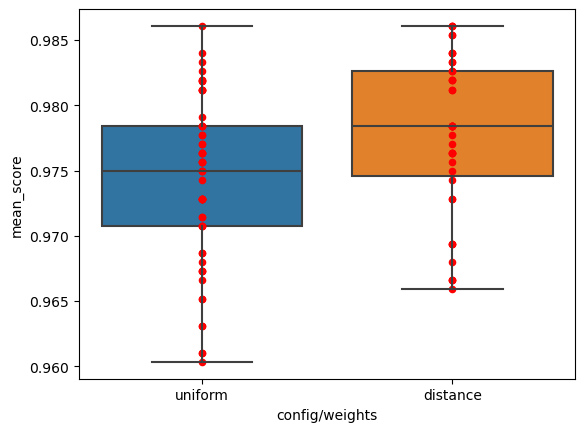

In [ ]:
#| fig-cap: "uniform与distance方法平均准确率箱线图对比"
#| fig-alt: "每一个红点是一次实验结果，平均准确率是每一次实验中五折交叉验证的平均值。"
fig, ax = plt.subplots()
sns.boxplot(data=dfi, x='config/weights', y='mean_score', ax=ax)
dfi.plot(x='config/weights', y='mean_score', ax=ax, kind='scatter', c='red')

以上的结果并没有控制变量，是直接进行了一个统计。相关性不代表因果性，所以上面的结果仅仅代表了在我们调参采样过程中，自变量“weights”与因变量“mean_score”的一定的相关性。
如果我们不知道每一次实验具体的其他的无关变量，上面的图我们也可以做一个合理的假设检验（验证我们的实验假设的零假设是否要拒绝！）。

根据论文[@Demšar_2006]，在机器学习中应该使用mann-whitney U检验和Wilcoxon signed-rank检验，因为这两个检验对样本的分布没有假定，而其他的一些检验比如t检验不太适用与样本分布不符合假设分布的情况。其中对于 “不知道每一次实验的其他无关变量是什么”的情况，也就是说自变量取“distance”和“uniform”得到的两列样本是独立（independent）的时候，应当使用mann-whitney U检验。

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
grouped = dfi.groupby('config/weights')
group_mean_scores = {name:group['mean_score'] for name, group in grouped}
scores_for_distance = group_mean_scores['distance']
scores_for_uniform = group_mean_scores['uniform']
u, p = mannwhitneyu(scores_for_distance, scores_for_uniform, 
                    alternative='greater' # 实验备则假设，distance 方法更好
                    )
if p < 0.05:
    print("Reject null hypothesis! `distance` is significantly better than `uniform`")

Reject null hypothesis! `distance` is significantly better than `uniform`


刚才我们只是整体分析。
接下来我们要寻找控制其他变量最优时，两个方法各自最优的参数是什么？以及这两个方法对哪些超参数比较敏感？

我们先回答第一个问题，我们从刚才的表格筛选一下。

In [ ]:
max_rows = dfi.loc[df.groupby('config/weights')['mean_score'].idxmax()]
max_rows

,mean_score,std_score,score_0,score_1,score_2,score_3,score_4,config/weights,config/n_neighbors,config/distance_metric
3,0.98608,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,distance,1,euclidean
36,0.98608,0.003125,0.986111,0.989583,0.982578,0.982578,0.989547,uniform,1,l2


这里我们可以对5次实验的结果进行统计分析，由于这五次实验是相关的，即这五次实验每一次用的同一个fold去训练，所以这里我们不应当用mann-whitney U检验，这一次我们要用Wilcoxon signed-rank检验。

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
#| hide
[v for k, v in max_rows.iloc[0].to_dict().items() if k.startswith('score_')]

[0.9861111111111112,
 0.9895833333333334,
 0.9825783972125436,
 0.9825783972125436,
 0.9895470383275261]

In [ ]:

scores_for_distance = [v for k, v in max_rows.iloc[0].to_dict().items() if k.startswith('score_')]
scores_for_uniform = [v for k, v in max_rows.iloc[1].to_dict().items() if k.startswith('score_')]
u, p = wilcoxon(scores_for_distance, scores_for_uniform, 
                zero_method='zsplit',
                    alternative='greater' # 实验备则假设，distance 方法更好
                    )
if p> 0.05:
    print("Null hypothesis cannot be rejected, so I have to accept it. ")

Null hypothesis cannot be rejected, so I have to accept it. 


/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


原来，当我们控制无关变量最优时，两个方法的性能能达到一致。具体来说，这里种找到的最优超参数正好是让knn的k为1，所以这个情况下distance方法和n_neighbors方法没有区别。按照谷歌调参手册的科研方法，对于这个数据集来说就无法说明这两个方法的优劣了。

然而，我个人认为，一个方法之所以被学术界认为有价值，在于这个方法能被其他人follow和cite。什么样的方法能对其他人的工作有帮助，什么样的方法就有价值。形式化一点来说，对 “其他人的工作”这个随机分布而言，我们的方法“应用上去之后，比不应用我们的方法或者使用其他方法更好”这个随机变量的期望值就是我们做科研应该追求的价值。

需要注意的是，“其他人的工作”由于他们计算资源以及研究者认知的局限，是比较不可能为你的方法调整整个实验流程其他的元参数或者说无关变量的。换句话说，如果你的方法需要其他人为你的方法来调参才能表现良好，那么你的方法的价值其实也是比较有限的。

在这里我们就遇到这个情况，在大部分随机的无关变量上，我们看到假设检验拒绝了零假设，说明distance方法期望地来说是对其他研究人员有帮助的，然而当调参到最优时，他们又都能达到最好。


现在我们回答第二个问题，这两个方法分别对其他元参数的敏感性如何?
首先分析对n_neighbors的敏感性。这个是通过quasi random search采样的。

In [ ]:
import copy

In [ ]:
#| export
# 为了解决seaborn开发者不愿意支持用户看到拟合曲线参数的问题，我们查找到了下面的解决方案
# 本代码参考 https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn
def regplot(
    *args,
    line_kws=None,
    marker=None,
    scatter_kws=None,
    **kwargs
):
    # this is the class that `sns.regplot` uses
    plotter = sns.regression._RegressionPlotter(*args, **kwargs)

    # this is essentially the code from `sns.regplot`
    ax = kwargs.get("ax", None)
    if ax is None:
        ax = plt.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)

    plotter.plot(ax, scatter_kws, line_kws)

    # unfortunately the regression results aren't stored, so we rerun
    grid, yhat, err_bands = plotter.fit_regression(plt.gca())

    # also unfortunately, this doesn't return the parameters, so we infer them
    slope = (yhat[-1] - yhat[0]) / (grid[-1] - grid[0])
    intercept = yhat[0] - slope * grid[0]
    return slope, intercept

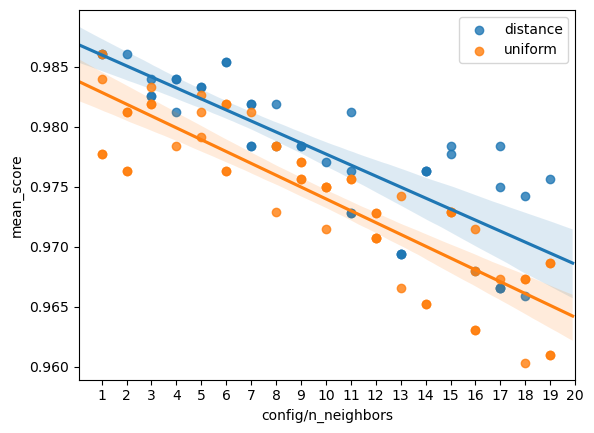

For distance, the regression line is y = -9.18e-04x + 9.87e-01
For uniform, the regression line is y = -9.86e-04x + 9.84e-01


In [ ]:
#| label: fig-n_neighbors
#| fig-cap: "Relationship between n_neighbors and mean_score"
#| fig-alt: "在图中我们画出了拟合的直线以及之前的95%置信区间。"
f = plt.figure()
ax = f.add_subplot(1,1,1)
line_dict = {}
for name, group in grouped:
    # plt.scatter(group['config/n_neighbors'], group['mean_score'], label=name)
    # p = sns.regplot(x='config/n_neighbors', y='mean_score', data=dfi, fit_reg=True, ax=ax)
    k, b = regplot(x='config/n_neighbors', y='mean_score', data=group, label=name, fit_reg=True)
    line_dict[name] = (k, b)
    

# sns.lmplot(x='config/n_neighbors', y='mean_score', data=dfi, hue="config/weights", fit_reg=True)
# 使用整数x坐标轴
plt.xticks(range(1, 21))
# plt.xlabel('n_neighbors')
# plt.ylabel('mean_score')
plt.legend()
# plt.title("Relationship between n_neighbors and mean_score")
plt.show()
# p.get_lines()[0].get_xdata(), p.get_lines()[0].get_ydata()
for name, (k, b) in line_dict.items():
    print(f"For {name}, the regression line is y = {k:.2e}x + {b:.2e}")

从图 @fig-n_neighbors 中可以看出，在数字识别问题上，无论是distance方法还是uniform方法，都是neighbors数量越多，精度反而越低。

从斜率上来看可能会以为这个问题很小，只是稍微减少了精度，但是从视觉上好像确实下降地很明显。我们为了从统计上说明清楚到底下降地显不显著，可以进一步通过皮尔森相关系数以及斯皮尔曼相关系数对应的假设检验来验证这个问题。

In [ ]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
def test_correlation_with(x, y, data, test_func, alpha=0.05):
    correlation, p_value = test_func(data[x], data[y])
    print(f"{test_func.__name__}  correlation coefficient: between {x} and {y}: {correlation}, p-value: {p_value}")
    if p_value < alpha:
        print("The correlation is significant!")
    else:
        print("The correlation is not significant.")

test_correlation_with('config/n_neighbors', 'mean_score', dfi, pearsonr)
test_correlation_with('config/n_neighbors', 'mean_score', dfi, spearmanr)

pearsonr  correlation coefficient: between config/n_neighbors and mean_score: -0.8148057329177487, p-value: 6.1435506488484e-25
The correlation is significant!
spearmanr  correlation coefficient: between config/n_neighbors and mean_score: -0.8085147488740115, p-value: 2.6833127946483235e-24
The correlation is significant!


### 附加任务: 尝试使⽤不同的策略来构建 KD 树，使得在分类阶段可以有更快的分类效率

注意我们这里探索要修改的目标是构建 KD 树的过程，也就是要改变KD树的结构，而不是修改KNN分类算法，主要也不是修改KD树的搜索算法。
这里我们的目标是让搜索的效率更高。


文献@KD-means中总结了KD树构造时的一些常见策略，其中最重要的就是splitting method。分割一个父节点的时候，我们需要决定1. 在哪个数据维度（𝑠𝑑）上进行划分 2. 这个维度上哪个值作为划分点。对于第一点，作者选择范围最广的维度（𝑚𝑎𝑥 − 𝑚𝑖𝑛）来进行划分。

对于第二点，作者选择了滑动中点分割规则，因为它比其他经典规则提供了更优化的数据组织。这种规则不会产生空节点或数据空间非常稀疏的节点。与选择中位数作为切割值的经典规则不同，滑动中点分割规则选择点的中间值（（最大值𝑚𝑎𝑥 + 最小值𝑚𝑖𝑛）/ 2），这样做成本更低。

作者还提到KD树的构建过程中可以限制KD树的深度。但是我不太懂如果限制了深度，不是叶子节点的地方在搜索时应该如何处理，退化为暴力吗？

在我们实现新的算法之前，我们首先测试一下没改进之前的算法的速度。

In [ ]:
#| eval: false
%timeit y_pred = knn_classifier(X_train, y_train, X_test, k_neighbors)

5.07 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


现在我们来实现更快的KD树。

In [ ]:
# 复用上面的一些定义
Node, euclidean_distance

(__main__.Node, <function __main__.euclidean_distance(x1, x2)>)

In [ ]:
#| export
from typing import Callable

In [ ]:
#| export
verbose = False
def fast_build_kd_tree(X, axis_order_list:list, strategy = "median", depth=0):
    if len(X) == 0:
        return None
    k = X.shape[1]
    # 根据当前深度，选择划分的维度
    # 原本是 
    # axis = depth % k 
    # axis = axis_order(depth, k)
    assert len(axis_order_list)==k, f"axis_order_list length should be equal to k, but got {len(axis_order_list)} with {axis_order_list}"
    axis = axis_order_list[depth % k]
    if verbose:
        print(" "*4*depth + f"Building kd-tree of depth {depth} with {len(X)} points, axis is {axis}")
    
    # 中位数策略
    if strategy == "median":
        X = X[X[:, axis].argsort()]
        median = X.shape[0] // 2 #将当前结点数据一分为二
        # assert len(np.where((X_train == X[median]).all(axis=1)))>0
        return Node(data=X[median], left=fast_build_kd_tree(X[:median], axis_order_list, strategy, depth + 1),
                    right=fast_build_kd_tree(X[median + 1:],axis_order_list, strategy,  depth + 1))
    
    # 中点策略
    else:
        x_axis = X[:, axis] # n个数
        middle_point_value = (x_axis.max()-x_axis.min()) / 2
        left_points = X[x_axis <= middle_point_value]
        right_points = X[x_axis > middle_point_value]
        distances_on_axis_to_middle = abs(x_axis - middle_point_value)
        closest_point_to_middle = distances_on_axis_to_middle.argmin()
        
        return Node(data=X[closest_point_to_middle], left=fast_build_kd_tree(left_points, axis_order_list,strategy, depth + 1), right=fast_build_kd_tree(right_points, axis_order_list, strategy, depth + 1))
    

In [ ]:
#| export
from queue import PriorityQueue

In [ ]:
#| export
def fast_search_kd_tree(tree, target, axis_order_list:list, k=3):
    if tree is None:
        return []
    # k_nearest = [] #list用于储存target当前遍历到的k个k近邻
    # 我们使用优先队列来储存k_nearest，从而提高效率，优先队列中的元素为(-距离, 节点)的元组，距离远的先取出来
    # k_nearest_pq = PriorityQueue(maxsize=k)
    k_nearest_pq = PriorityQueue()
    entry_count = 0
    stack = [(tree, 0)] #用于储存待遍历节点的stack
    while stack:
        node, depth = stack.pop() # 节点出栈
        if node is None:
            continue
        # print(" "*4*depth + f"node: {node.data}, depth: {depth}")
        distance = euclidean_distance(target, node.data) #计算需要分类的目标点与节点的距离
        
        # 调换到前面
        axis = depth % target.shape[0] #计算当前深度对应的划分维度
        axis = axis_order_list[axis] # 新增加
        # print(axis)
        
        axis_diff = target[axis] - node.data[axis] #计算该维度下目标点与当前节点的差
        
        #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则另一边的子树也入栈
        can_omit_another_side = True
        # if len(k_nearest) < k: # 当k_nearest未装满时，直接将节点放入
        # if k_nearest.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        if k_nearest_pq.qsize() < k: # 当k_nearest未装满时，直接将节点放入
        # if not k_nearest_pq.full(): # 当k_nearest未装满时，直接将节点放入
            # print(f"not full, put {(-distance, node)}")
            pass #BLANK_1
            # k_nearest.append((node, distance))
            k_nearest_pq.put((-distance, entry_count, node))
            entry_count+=1
            can_omit_another_side = False
        else: #当k_nearest装满时，对比该节点与k_nearest中与目标点距离最远的节点的距离，如果小于则替换，如果大于则不替换
            pass #BLANK_2
            farthest = k_nearest_pq.get()
            farthest_distance = -farthest[0]
            # print(f"full, farthest: {farthest}")
            if distance < farthest_distance:
                # print(f"closer, put {(-distance, node)}")
                # assert isinstance(distance, float)
                # print(k_nearest_pq.queue)
                k_nearest_pq.put((-distance, entry_count, node))
                entry_count+=1
            else:
                k_nearest_pq.put(farthest)
            

            if farthest_distance > abs(axis_diff): 
                can_omit_another_side = False
        
        if axis_diff <= 0: #当差小于0时则，该节点的左子树入栈 #如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则右子树也入栈
            pass #BLANK_3
            stack.append((node.left, depth+1))
            if not can_omit_another_side:
                stack.append((node.right, depth+1))
        else:#当差大于0时则，该节点的右子树入栈，#如果k_nearest未装满或k_nearest中相距目标点最远的点与目标点的距离大于axis_diff的绝对值时，则左子树也入栈
            pass #BLANK_4
            stack.append((node.right, depth+1))
            if not can_omit_another_side:
                stack.append((node.left, depth+1))
    # return [data for data, _ in k_nearest] #返回遍历完的kd树后的k_nearest
    # return [data for _, data in k_nearest] #返回遍历完的kd树后的k_nearest
    return [k_nearest_pq.get()[-1].data for i in range(k_nearest_pq.qsize())] #返回遍历完的kd树后的k_nearest

In [ ]:
#| export
# 由于我们需要记录axis_order， 所以要写成类
class FastKDTree:
    def __init__(self, X, split_value_strategy='median', axis_order_strategy='range') -> None:
        n, k = X.shape
        # 决定一下划分维度的顺序
        # 方差最大原则
        if axis_order_strategy == 'variance':
            self.axis_order_list = np.argsort(np.var(X, axis=0))
        # 极差最大原则
        elif axis_order_strategy == 'range':
            self.axis_order_list = np.argsort(np.max(X, axis=0) - np.min(X, axis=0))
        else:
            self.axis_order_list = np.arange(k)
        print(self.axis_order_list)
        self.root = fast_build_kd_tree(X, self.axis_order_list, split_value_strategy, 0)
    def search_kd_tree(self, point, k):
        return fast_search_kd_tree(self.root, point, self.axis_order_list, k)
    
    # 使用KNN算法分类
    def knn_classifier(self, X_train, y_train, X_test, k=3):
        y_pred = []
        for i, test_point in enumerate(X_test):
            k_nearest = self.search_kd_tree(test_point, k)
            # print(k_nearest)
            # print(k_nearest[0])
            # print(np.where((X_train == k_nearest[0]).all(axis=1)))
            labels = [y_train[np.where((X_train == point).all(axis=1))[0][0]] for point in k_nearest]
            counts = np.bincount(labels)#计算k_nearest中样本最多的标签，预测目标样本为该标签
            y_pred.append(np.argmax(counts))
        return y_pred
try:
    tree = FastKDTree(X_train, split_value_strategy='middle')
except Exception as e:
    print(e)

[ 0 32 39 31 24 56 16  8 40 47 48 23  1 57 15 55 33 38  7  9 30 25 10  4
 14 13 12 11  6  5  3  2 28 29 26 27 19 20 21 22 17 18 42 41 36 37 35 34
 46 45 44 43 51 52 50 49 54 53 58 59 60 61 62 63]
maximum recursion depth exceeded while calling a Python object


我们发现如果是用middle策略，由于数字识别数据集的分布特性，中点能划分的点太少，无法成功建树。

In [ ]:
# tree = FastKDTree(X, split_value_strategy="median")
tree = FastKDTree(X_train, split_value_strategy="median")

[ 0 32 39 31 24 56 16  8 40 47 48 23  1 57 15 55 33 38  7  9 30 25 10  4
 14 13 12 11  6  5  3  2 28 29 26 27 19 20 21 22 17 18 42 41 36 37 35 34
 46 45 44 43 51 52 50 49 54 53 58 59 60 61 62 63]


In [ ]:
for i in range(len(X_train)):
    k_nearest = tree.search_kd_tree(X_train[0], 1)
    where = np.where((X_train == k_nearest[0]).all(axis=1))
    where = where[0]
    assert len(where) == 1

In [ ]:
# k_nearest = tree.search_kd_tree(X_test[0], 2)
# k_nearest = tree.search_kd_tree(X_train[0], 2)
# k_nearest, X_train[0]
# k_nearest = tree.search_kd_tree(X_test[0], 2)
# k_nearest
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

0.9861111111111112

In [ ]:
#| eval: false
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

5.15 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


我们发现速度变慢了！
如果使用方差最大策略呢？会不会更好？

In [ ]:
tree = FastKDTree(X_train, split_value_strategy="median", axis_order_strategy='variance')
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

[ 0 32 39 56 24 16 31  8 40 48 47 23 15  1 57 55  7 63 49 41 25  9 22  6
 33 17 38 14 30 11 62  3 46  4 59  2 12 54 60 58 51 52 10 45 50  5 18 19
 37 29 61 36 27 53 13 28 26 20 21 35 34 44 43 42]


0.9861111111111112

In [ ]:
#| eval: false
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

5.5 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


甚至更慢！为了避免是因为我们实现新的方法有一定的overhead，我们对原本的划分策略也做一次测速。

In [ ]:
#| eval: false
tree = FastKDTree(X_train, split_value_strategy="median", axis_order_strategy='simple')
%timeit y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
5.37 s ± 310 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
y_pred = tree.knn_classifier(X_train, y_train, X_test, k_neighbors)
accuracy_score(y_test, y_pred) # 确保数值正确

0.9861111111111112

根据以上结果，我们初步得出结论，range划分方法比simple方法快，而simple方法比variance方法快。